# Descriptive statistics and normality testing

## Imports

In [1]:
import matplotlib.pyplot as pp
import pandas as pd
import pingouin as pg
import seaborn as sb

## Data loading

In [2]:
file_name = "../data/toy_descriptive_long.csv"
df = pd.read_csv(file_name)
df.head()

,group,value
0,S1,3
1,S1,3
2,S1,3
3,S1,4
4,S1,4


## Tabular analysis

- The `DataFrame` class from `pandas` provides the `describe` method for computing basic descriptive statistics.
- `describe` will ignore non-numeric columns

In [3]:
df.describe()

,value
count,45.000000
mean,7.600000
std,5.824712
min,1.000000
25%,4.000000
50%,6.000000
75%,8.000000
max,26.000000


The previous code has computed the statistics for the whole group. 
But we really want to break compute values by group.
We can "subset" our data as follows.

In [4]:
df[df["group"] == "S2"]

,group,value
15,S2,1
16,S2,1
17,S2,2
18,S2,2
19,S2,2
20,S2,3
21,S2,4
22,S2,5
23,S2,5
24,S2,6


The previous code gives us the subset of data from group S2.
Now we can run `describe` on that data.

In [5]:
df[df["group"] == "S2"].describe()

,value
count,15.000000
mean,7.600000
std,7.258493
min,1.000000
25%,2.000000
50%,5.000000
75%,12.500000
max,21.000000


In [6]:
df[df["group"] == "S3"].describe()

,value
count,15.000000
mean,7.600000
std,1.242118
min,5.000000
25%,7.000000
50%,8.000000
75%,8.500000
max,9.000000


If we want to describe for all groups we can use the `groupby` method.
> We are calling the `round` method on the result to format the output to two decimal places.

In [7]:
df.groupby(by="group").describe().round(2)

value                                      
      count mean   std  min  25%  50%   75%   max
group                                            
S1     15.0  7.6  7.24  3.0  4.0  5.0   7.0  26.0
S2     15.0  7.6  7.26  1.0  2.0  5.0  12.5  21.0
S3     15.0  7.6  1.24  5.0  7.0  8.0   8.5   9.0

## Basic plots

### Plotting data points

<Axes: xlabel='group', ylabel='value'>

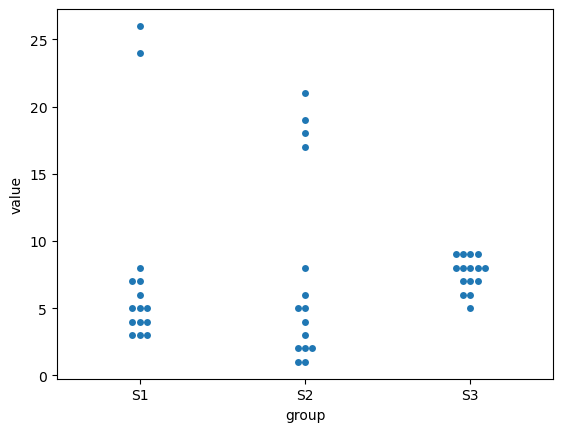

In [8]:
sb.swarmplot(df, x="group", y="value")

### Boxplots of the data distribution

<Axes: xlabel='group', ylabel='value'>

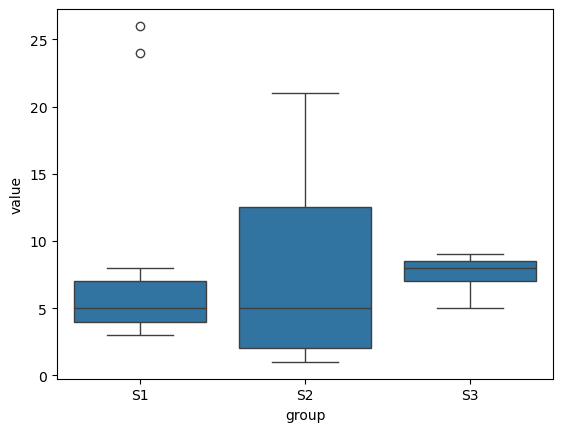

In [9]:
sb.boxplot(
    df,
    x="group",
    y="value",
)

### Interval plots

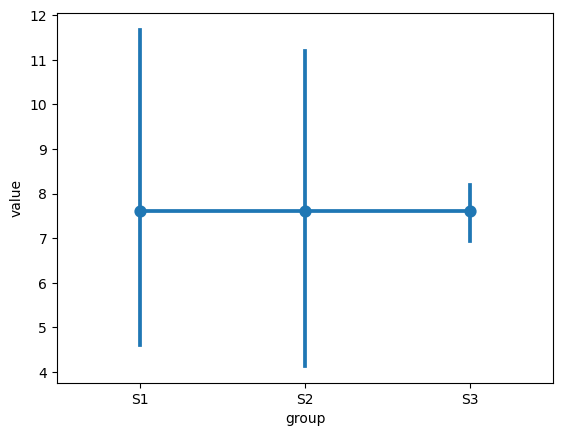

In [10]:
ax = sb.pointplot(
    df,
    x="group",
    y="value",
)

We need to get rid of the line connecting the groups.

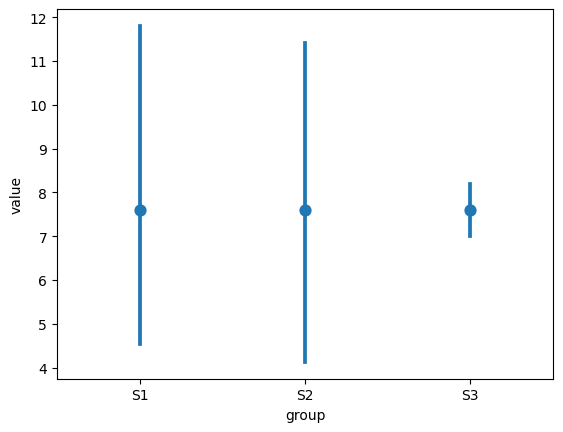

In [11]:
ax = sb.pointplot(
    df,
    x="group",
    y="value",
    linestyles="none",
)

By default we are getting the mean and standard devation.
Let's change to the median and IQR.
We will also add some horizontal bars to the ends of the range.

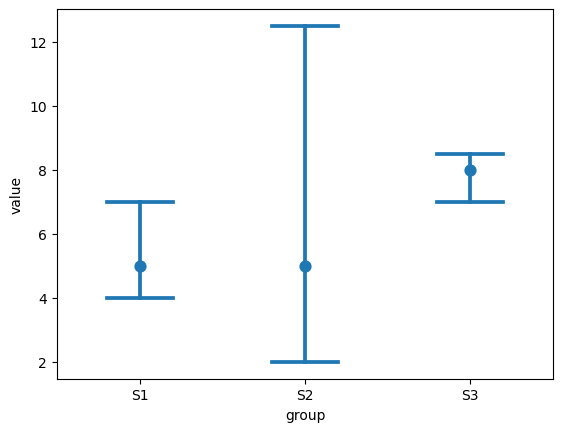

In [12]:
ax = sb.pointplot(
    df,
    x="group",
    y="value",
    capsize=0.4,
    estimator="median",
    errorbar=("pi", 50),
    linestyles="none",
)

## Combining plots

We can combine different types of plots.
Let's start by adding the data points to our boxplot.

Text(46.972222222222214, 0.5, 'Weight (g)')

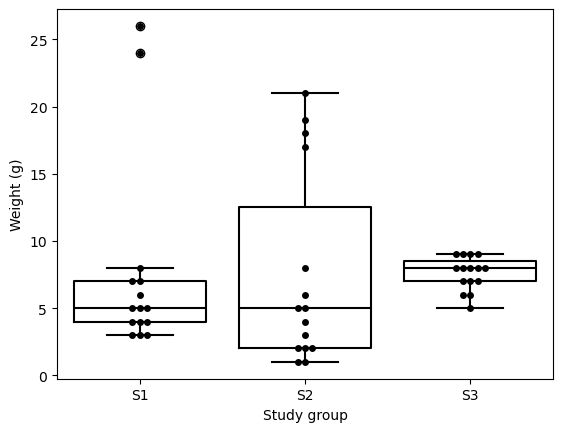

In [13]:
ax = sb.swarmplot(
    df,
    x="group",
    y="value",
    color="k",
)
ax = sb.boxplot(
    df,
    ax=ax,
    x="group",
    y="value",
    fill=False,
    color="k",
)
ax.set_xlabel("Study group")
ax.set_ylabel("Weight (g)")

We can do the same thing with our interval plots.

Text(46.972222222222214, 0.5, 'Weight (g)')

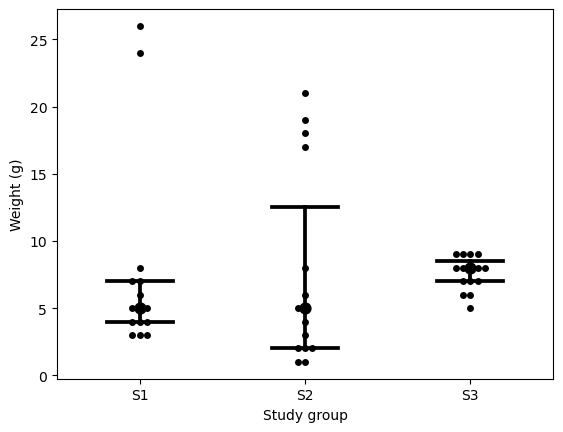

In [14]:
ax = sb.swarmplot(df, x="group", y="value", color="k")
ax = sb.pointplot(
    df,
    ax=ax,
    x="group",
    y="value",
    capsize=0.4,
    color="k",
    estimator="median",
    errorbar=("pi", 50),
    linestyle="none",
)
ax.set_xlabel("Study group")
ax.set_ylabel("Weight (g)")

### Histograms

Pandas DataFrames can plot histograms with the built in `hist` method.

array([[<Axes: title={'center': 'S1'}>, <Axes: title={'center': 'S2'}>],
       [<Axes: title={'center': 'S3'}>, <Axes: >]], dtype=object)

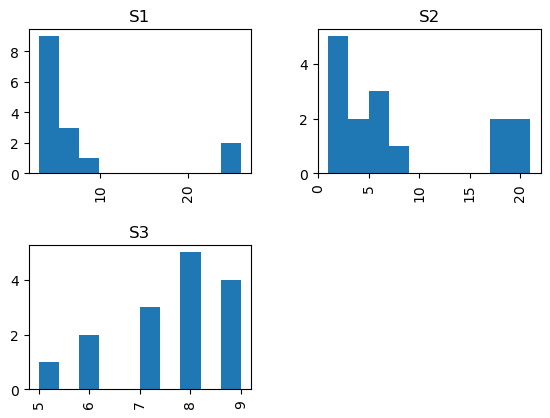

In [15]:
df.hist(by="group")

The default is pretty ugly.
We can lay things out one row and fix the figure size.

array([<Axes: title={'center': 'S1'}>, <Axes: title={'center': 'S2'}>,
       <Axes: title={'center': 'S3'}>], dtype=object)

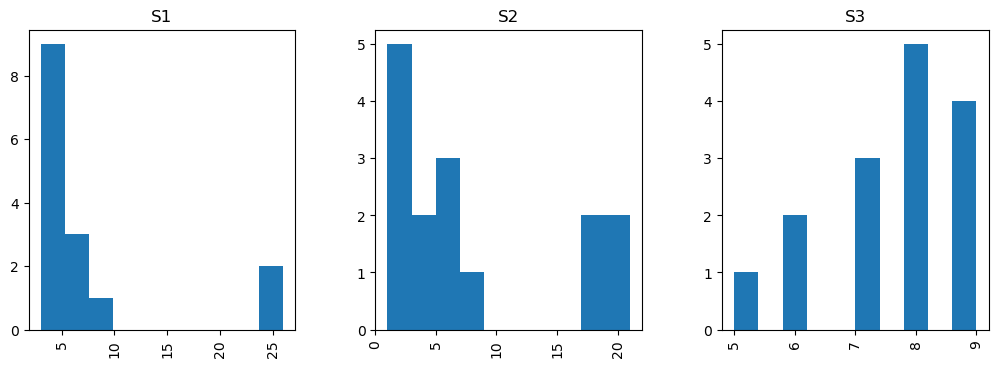

In [16]:
df.hist(by="group", figsize=(12, 4), layout=(1, 3))

While `pandas` has basic plotting support, `seaborn` is a lot more powerful.
Let's do the same thing in `seaborn`.

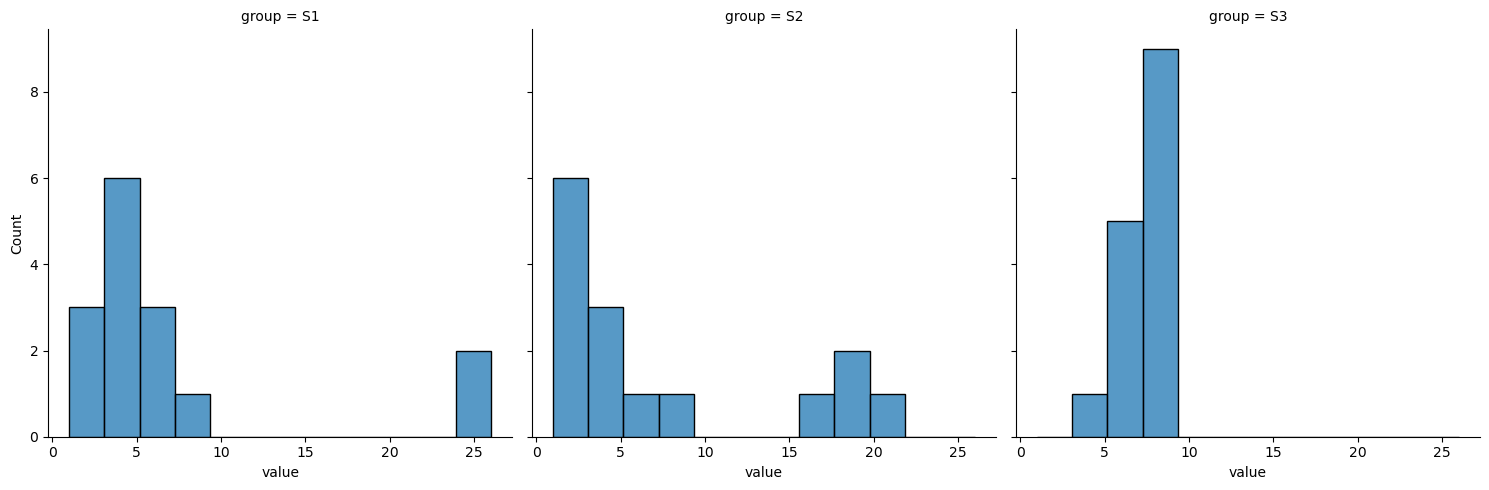

In [17]:
sb.displot(df, x="value", col="group")

The `distplot` function is a bit different than what we saw earlier, in that it produces multiple plots.
Instead of producing a single `Axes` object it produces a collection of `Axes` stored in a new object called a `FacetGrid`.
Let's clean up this plot.

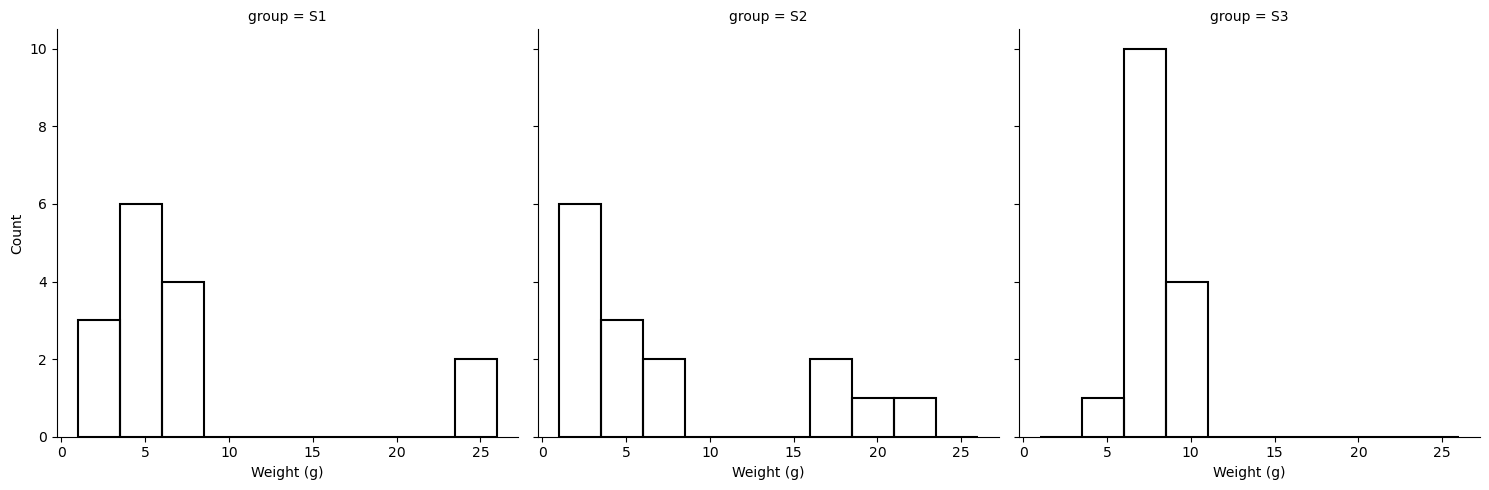

In [18]:
fg = sb.displot(df, x="value", col="group", bins=10, color="k", fill=False)
fg.set_xlabels("Weight (g)")

## Normality testing

We will use the `pingouin` package which provides a large collection of statistical functions.
To compute the Shapiro-Wilk statistics we will use the `normality` function.
This functions takes in a sequence of numbers.

In [19]:
pg.normality(df["value"])

,W,pval,normal
value,0.785754,0.000001,False


Again this is computing for the whole dataset.
We would rather do it by group.
This can be done by specifying the `dv` (dependent variable) and `group` arguments for the function.
> I am also specifying the `data` argument. In the previous example I did not because the `normality` function assumes the first argument is `data`. Strictly we can rely on that here as well, but I like to pass named arguments for clarity when possible.

In [20]:
pg.normality(data=df, dv="value", group="group")

,W,pval,normal
group,,,
S1,0.611780,0.000033,False
S2,0.792550,0.002955,False
S3,0.895845,0.082253,True


Let's round the results to 3 decimals for a slightly nicer display.

In [21]:
pg.normality(data=df, dv="value", group="group").round(3)

,W,pval,normal
group,,,
S1,0.612,0.000,False
S2,0.793,0.003,False
S3,0.896,0.082,True


Rounding looks a bit better, but now p-values < 0.001 are getting rounded to zero.
It would be nice to output "p < 0.001" in those cases.
Doing this requires a little bit of work, specificially we will need three concepts:

1. Writing a function, which is a reusuable piece of code that takes some inputs and returns some outputs based on those. We will write a function that takes a number and returns the rounded version if the number is greater than 0.001 and otherwise returns "p < 0.001"
2. We will use the `apply` method of a dataframe to pass each value in a column to our new function.
3. We will see the concept of converting data types. In this case we will convert from numbers to strings. A string is computer science terminology for a piece of text.

In [24]:
def format_p_val(p): # Starting our function
    if p < 0.001: # Check if our p-value is small
        result = "p < 0.001" # If so our result will be a string
    else:
        result = str(round(p, 3))
    return result # Send the result back to where the function was called

normal_test_results = pg.normality(data=df, dv="value", group="group")
normal_test_results["pval_formatted"] = normal_test_results["pval"].apply(format_p_val) # Use our function to format each p-value and save them in a new column
normal_test_results

,W,pval,normal,pval_formatted
group,,,,
S1,0.611780,0.000033,False,p < 0.001
S2,0.792550,0.002955,False,0.003
S3,0.895845,0.082253,True,0.082


If we want to do QQ plots we will can use the `qqplot` function.
There is not a really nice way to do it by group, so we will manually subset.

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

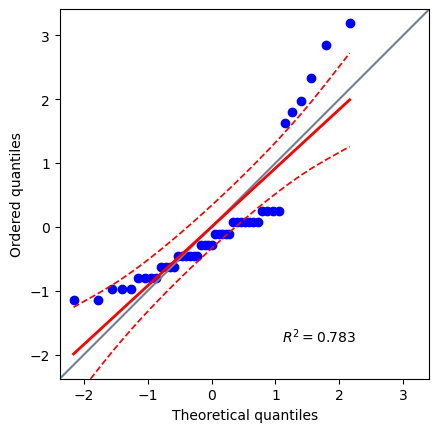

In [25]:
pg.qqplot(df["value"])

By default `qqplot` adds confidence intervals.
We can remove them by setting the `confidence` argument to `False`.

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

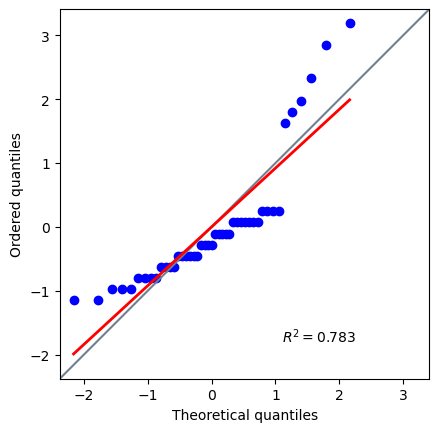

In [26]:
pg.qqplot(df["value"], confidence=False)

Again this does the qqplot for all groups together, but we would really like to do it by group.
The simplest way is to use indexing to select the values we want.
For example for group `S2` we could the following.

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

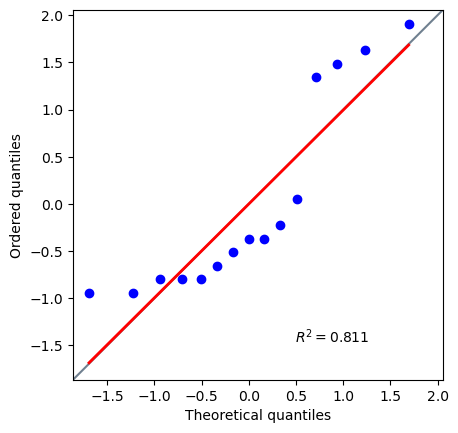

In [27]:
pg.qqplot(df.loc[df["group"] == "S2", "value"], confidence=False)

We could create separate cells for each group.
But it is simpler to use a `for` loop to sequentially create the plots.

The first thing we will do is get the group names and store them in a variable.

In [28]:
groups = df["group"].unique()
groups

array(['S1', 'S2', 'S3'], dtype=object)

Now we can loop over the groups and select the relevant ones.

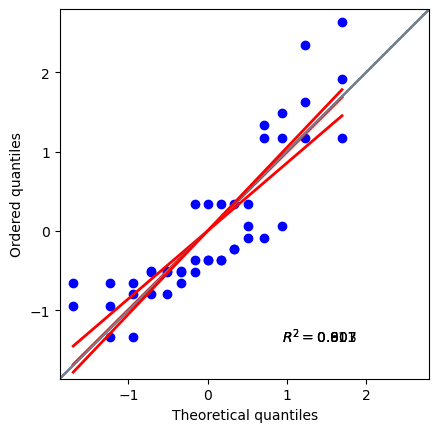

In [29]:
for g in groups:
    pg.qqplot(df.loc[df["group"] == g, "value"], confidence=False)

This does not give quite the right result, because the results are all being plotted on the same `Axes` object.
To fix this we will have to create new ones in the loop and pass them as arguments.
We can do this using the `matplotlib` library, specifically the `pyplot` module that I imported as `pp`.

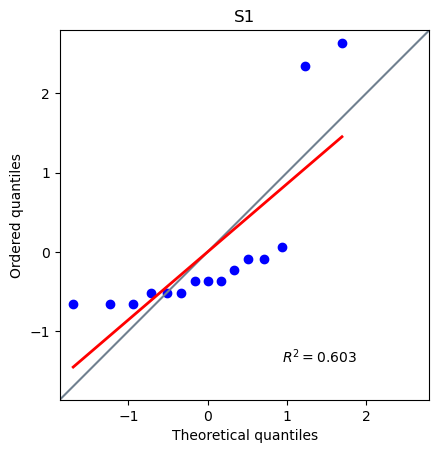

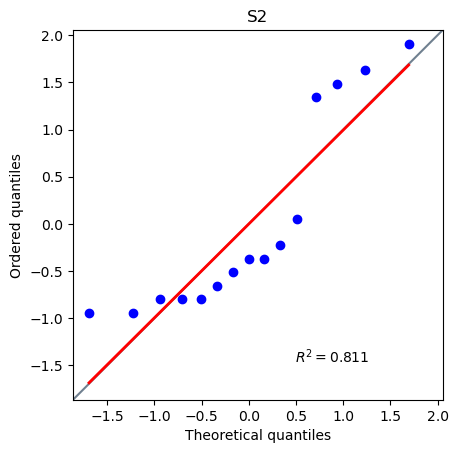

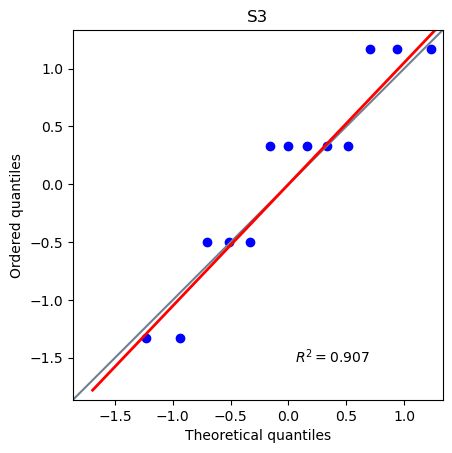

In [30]:
for g in groups:
    fig = pp.figure()  # Create a new figure to hold the Axes
    ax = fig.add_subplot(1, 1, 1)  # Add the figure to the axis
    pg.qqplot(
        df.loc[df["group"] == g, "value"],
        ax=ax,
        confidence=False,
    )
    ax.set_title(g) # Add a title so we know which group we are looking at

In the previous example we created separate figures for each `Axes` object.
This is not required, as figures can contain multiple `Axes` which is useful for building more complex plots.
Let's place all the `Axes` in one figure and plot horizontally.

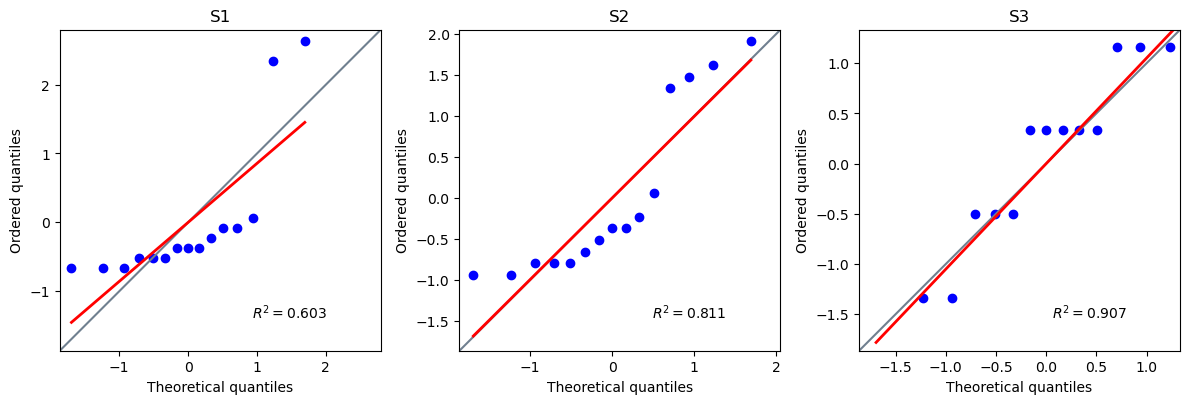

In [31]:
fig = pp.figure(figsize=(12, 4)) # Adding the figsize argument to expand the figure for horizontal layout.
for i, g in enumerate(groups): # Using enumerate to count which group we are at
    ax = fig.add_subplot(1, 3, i + 1) # The first argument specifies number of rows, second number of columns, third the index of the axes (1-based)
    pg.qqplot(
        df.loc[df["group"] == g, "value"],
        ax=ax,
        confidence=False,
    )
    ax.set_title(g) # Add a title so we know which group we are looking at
fig.tight_layout() # Fixes the axes positions so they don't overlap
#fig.savefig("my_plot.png") # Optionally save the figure